In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = '/content/drive/My Drive/kaggle/atmacup11/'
os.chdir(path) # カレントディレクトリを指定
os.getcwd()

'/content/drive/My Drive/kaggle/atmacup11'

In [3]:
!pip install lightly
!pip uninstall -y scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install ttach
!pip install optuna

     |████████████████████████████████| 240 kB 7.9 MB/s 
     |████████████████████████████████| 813 kB 13.4 MB/s 
     |████████████████████████████████| 144 kB 23.3 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 112 kB 29.3 MB/s 
     |████████████████████████████████| 636 kB 29.5 MB/s 
     |████████████████████████████████| 118 kB 36.3 MB/s 
     |████████████████████████████████| 234 kB 42.4 MB/s 
     |████████████████████████████████| 829 kB 36.4 MB/s 
     |████████████████████████████████| 10.6 MB 55.6 MB/s 
     |████████████████████████████████| 1.3 MB 43.6 MB/s 
     |████████████████████████████████| 142 kB 60.7 MB/s 
     |████████████████████████████████| 294 kB 47.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141229 sha256=b2bbd20d875cdc8b3442af82da24aef82ecde8cff6b9b44975f9b94504420307
  Stored in

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.9 MB 53.0 MB/s 
     |████████████████████████████████| 301 kB 7.6 MB/s 
     |████████████████████████████████| 164 kB 14.9 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 111 kB 13.2 MB/s 
     |████████████████████████████████| 141 kB 13.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d9a7f8d1cb09c7735c8abf7102cebe1e3818d4d71468076a5bdc8b70ff0c3a65
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Code

In [4]:
import os
import math
import torch
import torch.nn as nn
import torchvision
import numpy as np
import lightly

In [5]:
num_workers = 2
batch_size = 256
seed = 1
epochs = 400
input_size = 224

# dimension of the embeddings
num_ftrs = 512
# dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512
# the prediction head uses a bottleneck architecture
pred_hidden_dim = 128
# use 2 layers in the projection head
num_mlp_layers = 2

In [6]:
torch.manual_seed(0)
np.random.seed(0)

# set the path to the dataset
dataset_root = os.path.join(path, 'dataset_atmaCup11/')
assert dataset_root is not None

input_dir = os.path.join(dataset_root)
path_to_data = os.path.join(input_dir, "photos")
# path_to_data = './imgs/'

In [7]:
# Data Augmentation
collate_fn = lightly.data.ImageCollateFunction(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

dataset_train_simsiam = lightly.data.LightlyDataset(
    input_dir=path_to_data
)
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [11]:
resnet = torchvision.models.resnet18(pretrained=False)
backbone = nn.Sequential(*list(resnet.children())[:-1])

# create the SimSiam model using the backbone from above
model = lightly.models.SimSiam(
    backbone,
    num_ftrs=num_ftrs,
    proj_hidden_dim=pred_hidden_dim,
    pred_hidden_dim=pred_hidden_dim,
    out_dim=out_dim,
    num_mlp_layers=num_mlp_layers
)

In [13]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.SymNegCosineSimilarityLoss()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=5e-4
)

In [ ]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):

    for (x0, x1), _, _ in dataloader_train_simsiam:

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # the output of the simsiam model is a y containing the predictions
        # and projections for each input x
        y0, y1 = model(x0, x1)

        # backpropagation
        loss = criterion(y0, y1)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output, _ = y0
        output = output.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
        f'Loss = {avg_loss:.2f} | '
        f'Collapse Level: {collapse_level:.2f} / 1.00')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch   0] Loss = -0.59 | Collapse Level: 0.28 / 1.00
[Epoch   1] Loss = -0.69 | Collapse Level: 0.31 / 1.00
[Epoch   2] Loss = -0.73 | Collapse Level: 0.39 / 1.00
[Epoch   3] Loss = -0.73 | Collapse Level: 0.42 / 1.00
[Epoch   4] Loss = -0.68 | Collapse Level: 0.49 / 1.00
[Epoch   5] Loss = -0.74 | Collapse Level: 0.45 / 1.00
[Epoch   6] Loss = -0.77 | Collapse Level: 0.56 / 1.00
[Epoch   7] Loss = -0.76 | Collapse Level: 0.49 / 1.00
[Epoch   8] Loss = -0.73 | Collapse Level: 0.54 / 1.00
[Epoch   9] Loss = -0.69 | Collapse Level: 0.45 / 1.00
[Epoch  10] Loss = -0.69 | Collapse Level: 0.47 / 1.00
[Epoch  11] Loss = -0.81 | Collapse Level: 0.53 / 1.00
[Epoch  12] Loss = -0.73 | Collapse Level: 0.52 / 1.00
[Epoch  13] Loss = -0.84 | Collapse Level: 0.63 / 1.00
[Epoch  14] Loss = -0.81 | Collapse Level: 0.61 / 1.00
[Epoch  15] Loss = -0.71 | Collapse Level: 0.51 / 1.00
[Epoch  16] Loss = -0.83 | Collapse Level: 0.67 / 1.00
[Epoch  17] Loss = -0.74 | Collapse Level: 0.57 / 1.00
[Epoch  18

In [ ]:
backbone = model.backbone
# backbone.add_module('fc', nn.Linear(in_features=512, out_features=1, bias=True))
backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
output_dir = os.path.join(path, 'output/')
torch.save(backbone.state_dict(), os.path.join(output_dir, './simsiam/model.pth'))

# Train & Inference

In [ ]:
import os

import pandas as pd
import numpy as np
from glob import  glob

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from PIL import Image
from torchvision import transforms as T

import torch
from torchvision.models import resnet18, resnet34, resnet50
from torch import nn
from torch.optim import Adam
from torch.utils import data
from torch.optim.optimizer import Optimizer
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold

In [ ]:
import warnings
warnings.simplefilter('ignore')

input_dir = os.path.join(path, 'dataset_atmaCup11/')
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(path, 'output/')
os.makedirs(output_dir, exist_ok=True)

photo_pathes = glob(os.path.join(photo_dir, "*.jpg"))

def seed_torch(seed=510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
EPOCHS = 200
IS_REGR = False
IS_THRESHOLD = False
IS_SOFTLABEL = False
LERNING_RATE = 1e-3
LERNING_RATE = 1e-4
BATCH_SIZE = 256
SIZE = (224, 224)

In [ ]:
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

if IS_REGR:
  train_df['label'] = train_df['target']
  train_df['target'] = np.log1p(train_df['sorting_date'])
  thresh_0 = np.log1p(1440)
  thresh_1 = np.log1p(1600)
  thresh_2 = np.log1p(1700)
  thresh_3 = np.log1p(1800)
  print(thresh_0, thresh_1, thresh_2, thresh_3)
  train_df['label_log1p'] = train_df['label'].map({0: thresh_0, 1: thresh_1, 2: thresh_2, 3: thresh_3})
  train_df['label_log1p'][:10]
elif IS_SOFTLABEL:
  train_df['label'] = train_df['target']
  train_df['target'] = train_df['sorting_date'] / 100.0 - 15.51

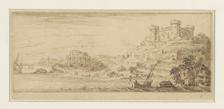

In [ ]:
def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

img = read_image(train_df['object_id'].iat[0])
img

In [ ]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = SIZE

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [ ]:
train_meta_df = train_df[['target', 'object_id']].copy()
train_meta_df['object_path'] = train_meta_df['object_id'].map(to_img_path)

dataset = AtmaDataset(meta_df=train_meta_df)
loader = data.DataLoader(dataset=dataset, batch_size=54, num_workers=4)

In [ ]:
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")
print(DEVICE)

cuda


In [ ]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()

    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)

    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    return pd.Series(metrics).add_prefix("train_")

In [ ]:
# from sklearn.model_selection import KFold

# fold = KFold(n_splits=5, shuffle=True, random_state=510)
fold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=510)
if IS_REGR or IS_SOFTLABEL:
  cv = list(fold.split(X=train_df, y=train_df['label'], groups=train_df['art_series_id']))
else:
  cv = list(fold.split(X=train_df, y=train_df['target'], groups=train_df['art_series_id']))
  # cv = list(fold.split(X=train_df))

In [ ]:
import ttach as tta

def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()

    predicts = []

    # TTA
    transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
        ]
    )
    tta_model = tta.ClassificationTTAWrapper(model, transforms)

    for x_i, y_i in loader:

        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = tta_model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""
    # return regression_metrics(y_true, y_pred)

    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """

    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)

    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

In [ ]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str, 
    n_epochs) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    os.makedirs(output_i, exist_ok=True)

    optimizer = Adam(model.parameters(), lr=LERNING_RATE)
    train_dataset = AtmaDataset(meta_df=train_df)
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)

    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
    valid_loader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=4)

    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None

    for epoch in range(1, n_epochs + 1):
        print(f'start epoch: {epoch}')

        score_train = train(model, optimizer, train_loader)
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)


        # --- 学習のロスと検証スコアの値をデータフレームに追加
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        train_loss = row['train_loss'][0]
        valid_rmse = row['valid_rmse'][0]
        print(f'epoch: {epoch}, train_loss: {train_loss}, valid_rmse: {valid_rmse}')
        # print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---

        # 今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_score = current_score
            valid_best_pred = y_valid_pred

    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return valid_best_pred

In [ ]:
def make_simsiam_model(model_path):
    # dimension of the embeddings
    num_ftrs = 512
    # dimension of the output of the prediction and projection heads
    out_dim = proj_hidden_dim = 512
    # the prediction head uses a bottleneck architecture
    pred_hidden_dim = 128
    # use 2 layers in the projection head
    num_mlp_layers = 2

    resnet = torchvision.models.resnet18(pretrained=False)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    model = lightly.models.SimSiam(
        backbone,
        num_ftrs=num_ftrs,
        proj_hidden_dim=pred_hidden_dim,
        pred_hidden_dim=pred_hidden_dim,
        out_dim=out_dim,
        num_mlp_layers=num_mlp_layers
    )
    model = model.backbone
    model.load_state_dict(torch.load(model_path))

    #最終層に全結合層を追加
    model.add_module('flatten', nn.Flatten())
    backbone.add_module('fc', nn.Linear(in_features=512, out_features=1, bias=True))
    return backbone

In [ ]:
%%time
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simsiam', f'cv={n_cv}')

oof = np.zeros((len(train_df), ), dtype=np.float32)

for i, (idx_tr, idx_valid) in enumerate(cv):
    print(f'***** fold: {i} *****')
    output_i = get_output_dir(i)
    # model = resnet34(pretrained=False)
    # model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    model = make_simsiam_model(os.path.join(output_dir, './simsiam/model.pth'))

    model.to(DEVICE)

    oof_i = run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        output_dir=output_i,
        n_epochs=EPOCHS
    )

    oof[idx_valid] = oof_i

***** fold: 0 *****
start epoch: 1
epoch: 1, train_loss: 1.6072179948797032, valid_rmse: 0.9601350407916712
validation score is improved!! inf -> 0.9601
start epoch: 2
epoch: 2, train_loss: 0.9510107265443218, valid_rmse: 0.943698064399039
validation score is improved!! 0.9601 -> 0.9437
start epoch: 3
epoch: 3, train_loss: 0.9416853402342115, valid_rmse: 0.9619919094621249
start epoch: 4
epoch: 4, train_loss: 0.924287740065127, valid_rmse: 0.9470976405362452
start epoch: 5
epoch: 5, train_loss: 0.9269635050880666, valid_rmse: 0.9172971450287365
validation score is improved!! 0.9437 -> 0.9173
start epoch: 6
epoch: 6, train_loss: 0.926230250876777, valid_rmse: 0.9268039504507158
start epoch: 7
epoch: 7, train_loss: 0.9208164178595251, valid_rmse: 0.920053596781876
start epoch: 8
epoch: 8, train_loss: 0.9022926092147827, valid_rmse: 1.0487533344816382
start epoch: 9
epoch: 9, train_loss: 0.8965927113075646, valid_rmse: 0.9412927048158103
start epoch: 10
epoch: 10, train_loss: 0.8975176418

In [ ]:
sns.distplot(oof)

In [ ]:
if IS_SOFTLABEL:
  oof = np.clip(oof, 0, 3)
print(calculate_metrics(train_df['target'], oof))

In [ ]:
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

# train と似たようなことをするので、次回から楽したいとおもって `create_metadata` という関数を作りました
test_meta_df = create_metadata(test_df)

# 学習時のデータ拡張はオフにしたいので is_train=False としている
test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)

In [ ]:
%%time
test_predictions = []

for i in range(len(cv)):
    print(f'cv: {i}')
    output_i = get_output_dir(i)

    # model = resnet34(pretrained=False)
    # model = resnet18(pretrained=False)
    # model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    # model_path = os.path.join(output_i, 'model_best.pth')
    model = make_simsiam_model(torch.load(model_path))

    # model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    y_pred_i = predict(model, loader=test_loader)
    test_predictions.append(y_pred_i)

In [ ]:
pred_mean = np.array(test_predictions).mean(axis=0)
if IS_SOFTLABEL:
  pred_mean = np.clip(pred_mean, 0, 3)

In [ ]:
import datetime
now = datetime.datetime.now()
print(now)
# sub.to_csv(f'../output/submission_{now.strftime("%m%d_%H%M")}.csv', index=False)

In [ ]:
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, f"submission_{now.strftime('%m%d_%H%M')}.csv"), index=False)